### Advanced Time Series Forecasting with Deep Learning and Attention Mechanisms

### 1. Imports Liberarey


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler


### 2. Load Dataset


In [5]:

import pandas as pd

# Replace with the actual path where ETTh1.csv is stored on your system
df = pd.read_csv(r"C:\Users\PRADHEEP\Downloads\Dataset\ETTh1.csv")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17420 entries, 0 to 17419
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    17420 non-null  datetime64[ns]
 1   HUFL    17420 non-null  float64       
 2   HULL    17420 non-null  float64       
 3   MUFL    17420 non-null  float64       
 4   MULL    17420 non-null  float64       
 5   LUFL    17420 non-null  float64       
 6   LULL    17420 non-null  float64       
 7   OT      17420 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.1 MB
None
                 date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0 2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1 2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2 2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3 2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4 2016-07-01 

### EDA

#### Data Cleaning

In [64]:


# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Drop duplicates if any
df = df.drop_duplicates()

# Handle missing values
# Option A: Drop rows with NaNs
df = df.dropna()

# Option B: Fill missing values (forward fill, then back fill)
# df = df.fillna(method='ffill').fillna(method='bfill')

numeric_cols = df.columns.drop('date')
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# 5. Remove extreme outliers (z-score > 3)
from scipy.stats import zscore
z_scores = np.abs(zscore(df[numeric_cols]))
df = df[(z_scores < 3).all(axis=1)]


print("Final shape after cleaning:", df.shape)

Missing values per column:
 date                0
HUFL                0
HULL                0
MUFL                0
MULL                0
LUFL                0
LULL                0
OT                  0
hour                0
month               0
OT_rolling_mean    23
OT_rolling_std     23
dtype: int64
Final shape after cleaning: (15996, 12)


In [66]:
df.describe()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,hour,month,OT_rolling_mean,OT_rolling_std
count,15996,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000
mean,2017-07-05 10:08:59.684921088,7.798114,2.239510,4.697362,0.861871,3.030508,0.885656,12.857423,11.446237,6.457489,12.854267,1.450490
min,2016-07-01 23:00:00,-13.731000,-3.885000,-16.167999,-4.335000,0.000000,-0.914000,-4.080000,0.000000,1.000000,-2.362417,0.000000
25%,2017-01-09 01:45:00,6.095000,0.737000,3.589000,-0.355000,2.315000,0.701000,6.753000,5.000000,3.000000,6.916521,0.969992
50%,2017-07-02 13:30:00,8.908000,2.210000,6.041000,0.924000,2.833000,0.975000,11.044000,11.000000,6.000000,10.928729,1.355722
75%,2018-01-02 11:15:00,11.788000,3.684000,8.635000,2.203000,3.594000,1.218000,17.516001,18.000000,10.000000,17.479042,1.846990
max,2018-06-26 19:00:00,23.643999,8.372000,17.341000,6.290000,6.549000,2.528000,38.972000,23.000000,12.000000,38.503250,3.699507
std,NaN,6.258740,2.027086,6.031083,1.795644,1.015455,0.543327,8.121524,6.963984,3.511532,7.989310,0.657654


#### Plot Target Variable


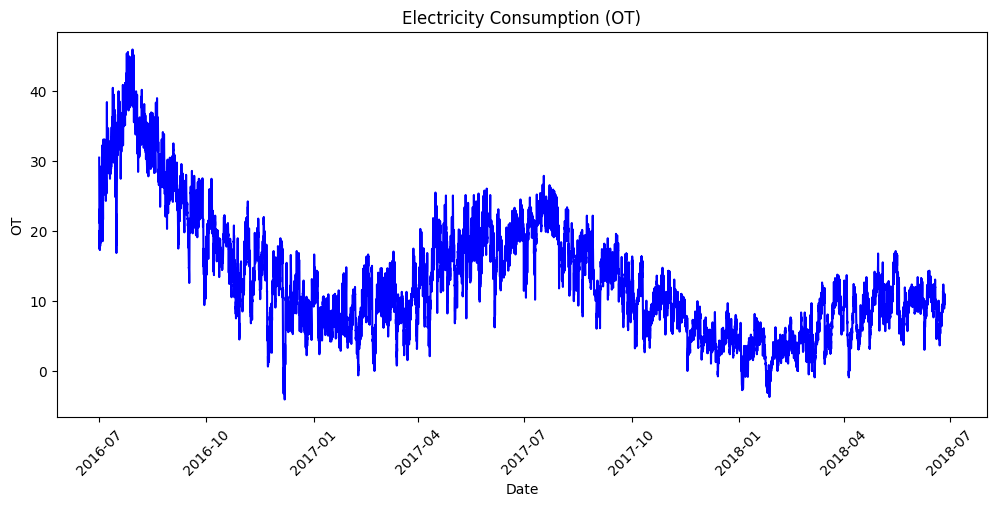

In [10]:
plt.figure(figsize=(12,5))
plt.plot(df['date'], df['OT'], color='blue')
plt.title("Electricity Consumption (OT)")
plt.xlabel("Date")
plt.ylabel("OT")
plt.xticks(rotation=45)
plt.show()


#### Correlation Heatmap

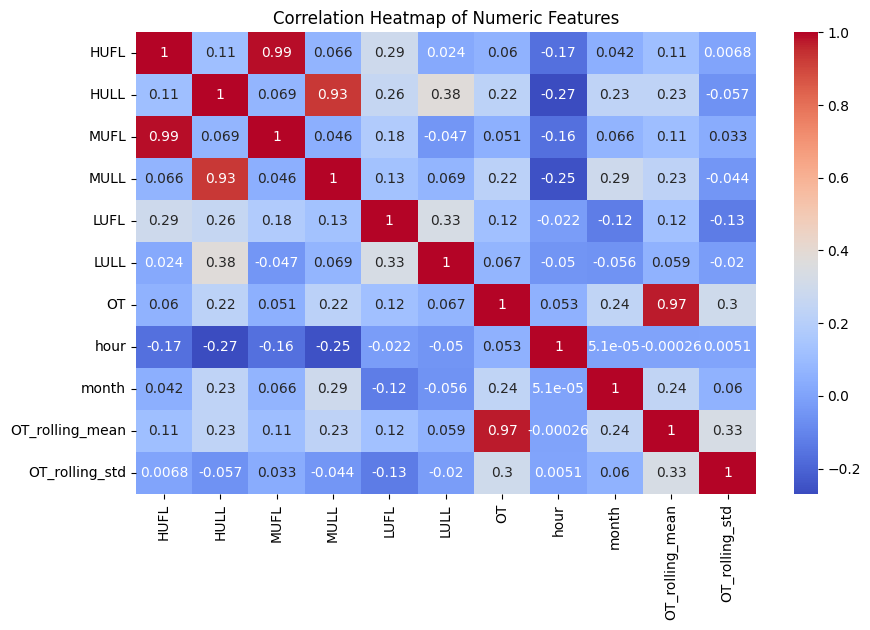

In [26]:
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


####  Hourly Pattern

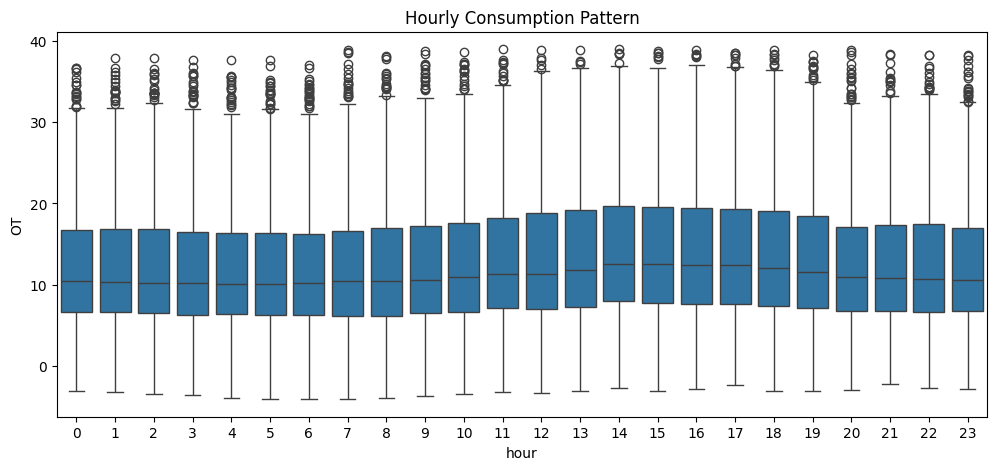

In [71]:
plt.figure(figsize=(12,5))
df['hour'] = df['date'].dt.hour
sns.boxplot(x='hour', y='OT', data=df)
plt.title("Hourly Consumption Pattern")
plt.show()

#### Monthly Pattern

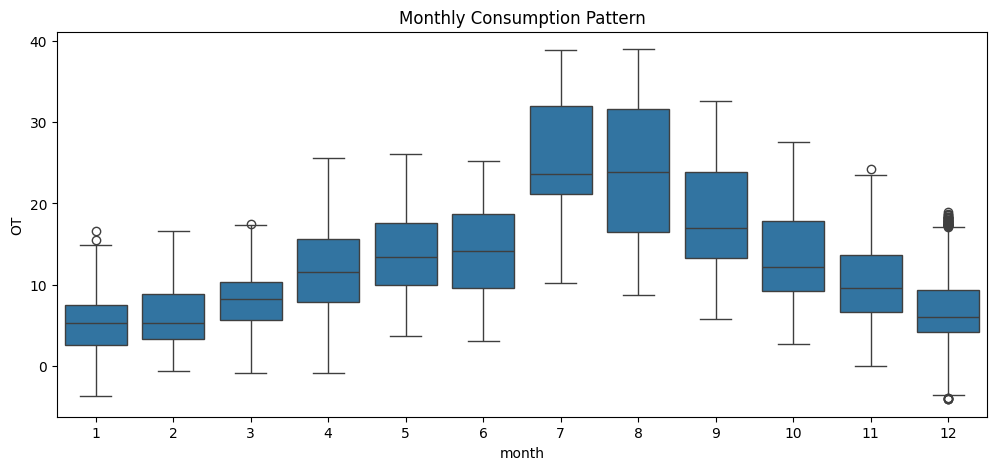

In [73]:
plt.figure(figsize=(12,5))
df['month'] = df['date'].dt.month
sns.boxplot(x='month', y='OT', data=df)
plt.title("Monthly Consumption Pattern")
plt.show()

#### Rolling Statistics

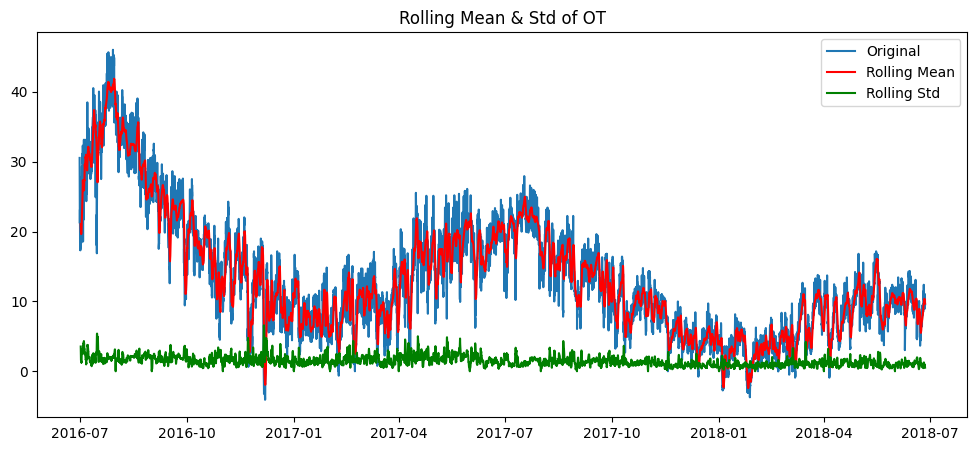

In [34]:
df['OT_rolling_mean'] = df['OT'].rolling(window=24).mean()
df['OT_rolling_std'] = df['OT'].rolling(window=24).std()

plt.figure(figsize=(12,5))
plt.plot(df['date'], df['OT'], label="Original")
plt.plot(df['date'], df['OT_rolling_mean'], label="Rolling Mean", color='red')
plt.plot(df['date'], df['OT_rolling_std'], label="Rolling Std", color='green')
plt.legend()
plt.title("Rolling Mean & Std of OT")
plt.show()

### 4. Preprocessing


In [37]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df.drop(columns=['date']))

def create_sequences(data, seq_len=48, horizon=24):
    X, y = [], []
    for i in range(len(data) - seq_len - horizon):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+horizon, 0])  # target: OT
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, seq_len=48, horizon=24)



### 5.Transformer Model

In [40]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, horizon):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(model_dim, horizon)

    def forward(self, x):
        x = self.embedding(x)      # [batch, seq_len, model_dim]
        out = self.transformer(x)  # [batch, seq_len, model_dim]
        out = out.mean(dim=1)      # aggregate across seq_len
        return self.fc_out(out)    # [batch, horizon]




### 6.Training Setup


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = TensorDataset(
    torch.tensor(X[:10000], dtype=torch.float32),
    torch.tensor(y[:10000], dtype=torch.float32)
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = TimeSeriesTransformer(
    input_dim=X.shape[2], model_dim=32, num_heads=2, num_layers=2, horizon=24
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)



### 7.Training Loop

In [47]:
for epoch in range(10):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_X)

        loss = criterion(output, batch_y)
        if torch.isnan(loss):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")




Epoch 1, Avg Loss: 0.5923
Epoch 2, Avg Loss: 0.5226
Epoch 3, Avg Loss: 0.5132
Epoch 4, Avg Loss: 0.5026
Epoch 5, Avg Loss: 0.5044
Epoch 6, Avg Loss: 0.4977
Epoch 7, Avg Loss: 0.4933
Epoch 8, Avg Loss: 0.4938
Epoch 9, Avg Loss: 0.4856
Epoch 10, Avg Loss: 0.4952


### 8.Evaluation


In [50]:
test_dataset = TensorDataset(
    torch.tensor(X[10000:], dtype=torch.float32),
    torch.tensor(y[10000:], dtype=torch.float32)
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
preds_list, actual_list = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        preds = model(batch_X)
        preds_list.append(preds.cpu().numpy())
        actual_list.append(batch_y.cpu().numpy())

preds = np.concatenate(preds_list, axis=0)
actual = np.concatenate(actual_list, axis=0)


### 9. Metrics


In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(actual.flatten(), preds.flatten()))
mae = mean_absolute_error(actual.flatten(), preds.flatten())
mape = np.mean(np.abs((actual.flatten() - preds.flatten()) / actual.flatten())) * 100

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")


RMSE: 1.2155, MAE: 0.9681, MAPE: 490.84%


### 10. Prediction Visualization

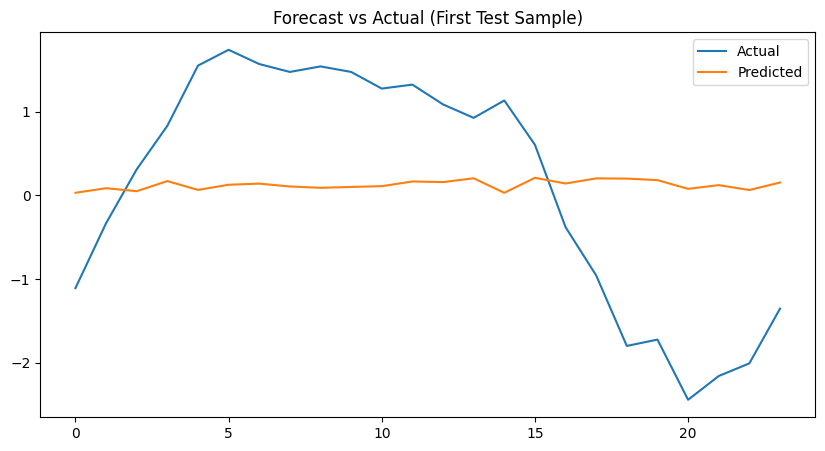

In [56]:
plt.figure(figsize=(10,5))
plt.plot(actual[0], label="Actual")
plt.plot(preds[0], label="Predicted")
plt.title("Forecast vs Actual (First Test Sample)")
plt.legend()
plt.show()


### Advanced Time Series Forecasting with Transformers